## 模型选择、欠拟合和过拟合

## 1. 模型选择

模型选择（model selection）是指在学习过程中，对模型的选择。模型训练需要有训练集，验证集和测试集，验证集是在模型训练完成后用来验证训练效果的（从样本中划分），测试集是模型训练完成后，验证集验证完后，评价模型用到的独立于样本外的数据，一般写代码偷懒验证集会写成训练集，但我们从训练样本下划分出来的用于评估模型数据的都是验证集。一般我们可以按一定比例选择验证集，如果样本数过少，我们可以用K-则交叉验证，即将训练数据分割成K块，每次使用第i块作为验证数据集，其余的作为训练集，最后计算K个验证集的平均误差，K一般取5或10。

## 2. 欠拟合和过拟合

欠拟合指模型不能够得到较低的训练误差。

过拟合指模型的训练误差远小于测试误差。

VC维：指一个模型可以对多少个样本进行完美的分类，而不产生错误。如果一个模型的VC维为d，则意味着该模型最多能够正确分类任意d个样本点的所有可能子集。当样本集的大小超过模型的VC维时，存在至少一个样本集无法被该模型完美分类。 

模型选择时：

- 模型容量需要匹配数据复杂度，否则可能导致欠拟合和过拟合。
- 统计机器学习提供数学工具来衡量模型复杂度。
- 实际中一般靠观察训练误差和验证误差。

#### 欠拟合的解决方法

- 增加新特征

- 增加多项式特征

#### 过拟合的解决方法

- 增大训练集

- 采用正则化

- 采用dropout

- 采用集成学习

## 3. 正则化与权重衰减

正则化（regularization）是结构风险最小化策略的实现，是在经验风险上加一个正则化项或罚项（penalty term）。

L1正则化

L1正则化是指权重向量$\mathbf{w}$中各个元素的绝对值之和，即：

$$\|\mathbf{w}\|_1=\sum\limits_{j=1}^n|w_j|$$

L2正则化

L2正则化是指权重向量$\mathbf{w}$中各个元素的平方和然后再求平方根，即：

$$\|\mathbf{w}\|_2=\sqrt{\sum\limits_{j=1}^nw_j^2}$$

可以利用对正则化后的参数大小做限制，来限制参数自身的大小，有了取值范围的参数模型容量会降低，能避免过拟合的情况。

即：

$\min~\ell(\mathbf{w},b)\quad\text{subject to}~\|\mathbf{w}\|^2\leq\theta $

等价于：

$\min~\ell(\mathbf{w},b)+\frac\lambda2\|\mathbf{w}\|^2$

超参数$\lambda$控制了正则项的重要程度，$\lambda \rightarrow 0$无作用，$\lambda \rightarrow \infin, \mathbf w\rightarrow \mathbf0$

梯度：

$\frac{\partial}{\partial\mathbf{w}}\left(\ell(\mathbf{w},b)+\frac{\lambda}{2}\|\mathbf{w}\|^2\right)=\frac{\partial\ell(\mathbf{w},b)}{\partial\mathbf{w}}+\lambda\mathbf{w}$

时间t更新参数：

$\mathbf{w}_{t+1}=(1-\eta\lambda)\mathbf{w}_{t}-\eta\frac{\partial\ell(\mathbf{w}_{t},b_{t})}{\partial\mathbf{w}_{t}}$

相比交于原来的：

$\mathbf{w}_{t+1}=\mathbf{w}_{t}-\eta\frac{\partial\ell(\mathbf{w}_{t},b_{t})}{\partial\mathbf{w}_{t}}$

可以看到每次递归都会先主动缩小原来的$\mathbf{w}_{t}$。

权重衰减演示

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
# 定义L2范数惩罚项
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.49917984008789


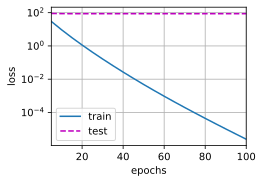

In [6]:
# 未使用权重衰减
train(lambd=0)

w的L2范数是： 0.3772825300693512


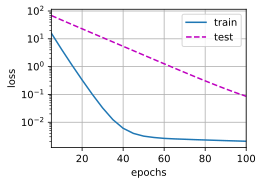

In [7]:
# 使用权重衰减
train(lambd=3)

In [8]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.74324893951416


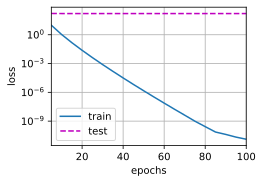

In [9]:
train_concise(0)

w的L2范数： 0.45782607793807983


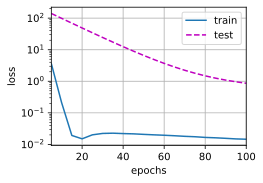

In [10]:
train_concise(3)

## 4. dropout

一个好的模型需要对输入数据的扰动鲁棒。

丢弃法：在层之间加入噪音。

对 $\mathbf{x}$ 加入噪音得到 $\mathbf{x}^{\prime}$, 我们希望

$\mathbf{E}[\mathbf{x}^\prime]=\mathbf{x}$

丢弃法对每个元素进行如下扰动：

$x_i'=\begin{cases}0&\text{with probablity} \space p\\\frac{x_i}{1-p}&\text{otherise}\end{cases}$

$p$是超参数。

通常将丢弃法作用在隐藏全连接层的输出上，将输出dropout后再传入下一个隐藏层。

正则项只在训练中使用，推理时$\mathbf{h}=\operatorname{dropout}(\mathbf{h})$。

In [ ]:
%reset
%whos

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
dropout1, dropout2 = 0.2, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [3]:
#不知道为什么d2l里没有train_ch3函数，所以把这些函数从2.5-1复制过来，假装我们在调库，不知道里面有这些函数
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回每一行最大值的索引，1表示按行
    # 注意这里的y并没有hot编码，所以直接比较就可以了
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

d2l.train_ch3 = train_ch3
d2l.predict_ch3 = predict_ch3

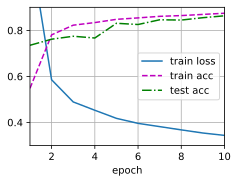

In [4]:
num_epochs, lr, batch_size = 10, 0.5, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 5. 数值稳定性

梯度爆炸：$1.5^{100}\approx4\times10^{17}$

- 值超出值域（infinity）

  对于16位浮点数尤为严重（数值区间6e-5—6e4）（一般我们用16位，速度更快，是32位的两倍）

- 对学习率敏感

  如果学习率太大→大参数值→＞更大的梯度

  如果学习率太小→训练无进展

  我们可能需要在训练过程不断调整学习率

梯度消失：$0.8^{100}\approx2\times10^{-10}$

- 梯度值变成0

  对16位浮点数尤为严重

- 训练没有进展

  不管如何选择学习率

- 对于底部层尤为严重

  仅仅顶部层训练的较好

  无法让神经网络更深

常发生在深度模型中，因为其会对n个数累乘。

让训练更稳定：

目标：让梯度值在合理的范围内

- 将乘法变加法，如ResNet,LSTM
- 归一化：梯度归一化，梯度裁剪
- 合理的权重初始和激活函数

下面重点讲一下第三个方法。

Xavier初始化：在神经网络中，每一层的输入和输出都受到权重$\mathbf w$的影响。 权重过大或过小都有可能导致梯度爆炸，但我们权重的初始值是随机选取，因此，我们可以从一个合理的分布中选取权重的初始值，保证数据的输入和输出方差控制在合理的范围，不会差距太大。由于保证了数据的方差，优化过程中$w$就不会跑到太离谱的范围，就可以避免梯度爆炸。

假设第t层的权重$\mathbf w_t$的方差为$\gamma_t$，输入向量维度为$n_{t-1}$，输出向量维度为$n_t$，则

$\gamma_t=2/(n_{t-1}+n_t)$

如果假设权重$\mathbf w_t$满足正态分布，则$\mathscr{N}\left(0,\sqrt{2/(n_{t-1}+n_{t})}\right)$，均匀分布的话$\mathcal{U}\left(-\sqrt{6/(n_{t-1}+n_{t})},\sqrt{6/(n_{t-1}+n_{t})}\right)$。